In [ ]:
from imp import reload
import os, time
import numpy as np
import pickle

# RNN model and task
import torch
use_cuda = torch.cuda.is_available()
from model import RNN, train, run_net
from task_generators import flipflop, mante, romo

# Data directory for saving
from data_dir import data_dir

In [2]:
### Shared parameters
optimizer = 'adam'

# Integration time step
dt = 0.5
# Training parameters
batch_size = 32
batch_size_test = 512
# Neural noise
noise_std = 0.
# Whether IO vectors are orthogonalized
orthogonalize_wio = False
# Same random connectivity for each g?
same_connectivity = False
# Reconstruction loss
n_ranks = 26

# Network architecture
ML_RNN = False
nonlinearity = 'tanh'
readout_nonlinearity = None

# Task names
tasks_file_name_prefix = ["flipflop", "mante", "romo"]
# Number of epochs
tasks_n_epochs = np.array([1000, 2000, 6000])
# Number of kept weight matrices (we don't really need this for the analysis...)
n_rec_epochs = 200

# Learning rate
lr0 = 0.05


In [3]:
scenario = ['full', 'test'][1]

if scenario == 'full':
    # Network size
    dim_rec = 256

    # Simulate and analyze all three tasks for multiple samples. 
    n_samples = 5

    # Values for g
    dg = 0.3
    tasks_g_max = [2.1, 2.7, 3.0]
    tasks_gs = [np.arange(0, g_max+dg, dg) for g_max in tasks_g_max]

    # What to train
    train_wi=True
    train_wrec=True
    train_wo=True
    train_brec=False

elif scenario == 'test':
    # For quick testing
    dim_rec = 256
    n_samples = 2
    n_epochs = 20
    tasks_n_epochs = np.array([n_epochs]*3)
    n_rec_epochs = n_epochs
    tasks_gs = [np.array([0., 1.8])]*3
    tasks_file_name_prefix = ["test_" + fn for fn in tasks_file_name_prefix]
    train_wi=False
    train_wrec=True
    train_wo=False
    train_brec=False

In [4]:
def run_training(task_specs):
    (file_name_prefix, n_epochs, gs, dims, task_params, task_generator
    ) = task_specs
    # Task
    task = task_generator(dims, dt, **task_params)
    n_gs = len(gs)
    dim_in, dim_rec, dim_out = dims
    
    # Epochs
    rec_step = n_epochs // n_rec_epochs
    epochs = np.arange(n_epochs)
    rec_epochs = np.arange(0, n_epochs, rec_step)
    
    # Learning rate
    if optimizer == 'sgd':
        lr = lr0
    elif optimizer == 'adam':
        lr = lr0 / dim_rec
    
    # For rank truncation
    ranks = np.arange(n_ranks) 
    rank_max = ranks[-1] + 1
    
    # Weights
    wi_init_all = np.zeros((n_samples, n_gs, dim_in, dim_rec))
    wrec_init_all = np.zeros((n_samples, n_gs, dim_rec, dim_rec))
    wo_init_all = np.zeros((n_samples, n_gs, dim_rec, dim_out))
    brec_init_all = np.zeros((n_samples, n_gs, dim_rec))
    wi_last_all = np.zeros((n_samples, n_gs, dim_in, dim_rec))
    wrec_last_all = np.zeros((n_samples, n_gs, dim_rec, dim_rec))
    wo_last_all = np.zeros((n_samples, n_gs, dim_rec, dim_out))
    brec_last_all = np.zeros((n_samples, n_gs, dim_rec))
    if train_wi:
        wis_all = np.zeros((n_samples, n_gs, n_rec_epochs, dim_in, dim_rec))
    if train_wo:
        wos_all = np.zeros((n_samples, n_gs, n_rec_epochs, dim_rec, dim_out))
    if train_brec:
        brecs_all = np.zeros((n_samples, n_gs, n_rec_epochs, dim_rec))
    # Results
    losses_all = np.zeros((n_samples, n_gs, n_epochs))
    grad_norms_all = np.zeros((n_samples, n_gs, n_epochs))
    sv_dw_all = np.zeros((n_samples, n_gs, n_rec_epochs, dim_rec))
    loss_rr_all = np.zeros((n_samples, n_gs, n_ranks))
    norm_diff_rr_all = np.zeros((n_samples, n_gs, n_ranks))
    var_expl_all = np.zeros((n_samples, n_gs, n_ranks))
    loss_shuff_all = np.zeros((n_samples, n_gs))
    ev_all = np.zeros((3, n_samples, n_gs, dim_rec), dtype=complex)
    sv_all = np.zeros((3, n_samples, n_gs, dim_rec))

    # Figure and file name
    file_name = file_name_prefix
    if n_gs == 1:
        g = gs[0]
        file_name += "_g_%.1f" % g
    else:
        file_name += "_gs"
    # RNN model
    if ML_RNN:
        file_name += "_ML_RNN"
    if not (nonlinearity == 'tanh' or nonlinearity == None):
        file_name += "_%s" % nonlinearity
    if not (readout_nonlinearity == 'tanh' or readout_nonlinearity == None):
        file_name += "_%s" % readout_nonlinearity
    # Optimizer
    if optimizer != 'sgd':
        file_name += '_' + optimizer
    # What is trained
    file_name += "_train"
    if train_wi:
        file_name += "_wi"
    if train_wrec:
        file_name += "_wrec"
    if train_wo:
        file_name += "_wo"
    if train_brec:
        file_name += "_brec"
    if same_connectivity:
        file_name += "_same_conn"
    if orthogonalize_wio:
        file_name += "_ortho_wio"
    if noise_std != 0:
        file_name += "_noise_%.1f"%noise_std
    # Network parameters
    file_name += "_N_%d"%dim_rec
    file_name += "_lr0_%.2f" % lr0
    file_name = "".join(file_name.split('.'))
    print("file_name:\n", file_name)
    # Data file for saving
    data_file_name = file_name + ".pkl"
    data_file = os.path.join(data_dir, data_file_name)
    print("data_file:\n", data_file)

    for k in range(n_samples):
        print("Sample", k)
        time_t = 0
        time_sv = 0
        time_r = 0
        time_ls = 0
        for i, g in enumerate(gs):
            print("   ", i, g)
            
            if (not same_connectivity) or i == 0:
                # Connectivity
                # Initial internal connectivity
                wrec_0 = np.random.normal(0, 1 / np.sqrt(dim_rec), (dim_rec, dim_rec))
                # Input and output vectors
                wio = np.random.normal(0, 1, (dim_rec, dim_in + dim_out))
                if orthogonalize_wio:
                    wio = np.linalg.qr(wio)[0]
                else:
                    wio /= np.linalg.norm(wio, axis=0)[None, :]
                # Make sure that the vecotrs are still normalized
                assert np.allclose(np.linalg.norm(wio, axis=0), 1), "Normalization gone wrong!"
                # Change normalization to the proper one
                wio *= np.sqrt(dim_rec)
                wi_init = wio[:, :dim_in].T.copy()
                wo_init = wio[:, dim_in:].copy() / dim_rec
                del wio

            wrec_init = g * wrec_0

            # Network
            net = RNN(dims, noise_std, dt, 
                      g=g, wi_init=wi_init, wo_init=wo_init, wrec_init=wrec_init,
                      train_wi=train_wi, train_wrec=train_wrec, train_wo=train_wo, train_brec=train_brec,
                      nonlinearity=nonlinearity, readout_nonlinearity=readout_nonlinearity, 
                      ML_RNN=ML_RNN,
                     )

            # Train
            time0_t = time.time()
            res = train(net, task, n_epochs, batch_size, lr, cuda=use_cuda, rec_step=rec_step, optimizer=optimizer, verbose=False)
            losses, grad_norms, weights_init, weights_last, weights_train, _, _ = res
            # Weights
            wi_init, wrec_init, wo_init, brec_init = weights_init
            wi_last, wrec_last, wo_last, brec_last = weights_last
            dwrec_last = wrec_last - wrec_init
            wrecs = weights_train["wrec"]
            time_t += time.time() - time0_t

            # Compute SVs
            time0_sv = time.time()
            sv_dw = np.linalg.svd(wrecs - wrec_init, compute_uv=False)
            del wrecs
            time_sv += time.time() - time0_sv

            # Reconstruct connectivty with only the largest rank
            time0_r = time.time()
            u_last, s_last, vT_last = np.linalg.svd(dwrec_last)
            # Variance explained
            cum_var_rr = np.r_[0, (s_last[:n_ranks - 1]**2).cumsum()]
            var_expl = cum_var_rr / (s_last**2).sum()
            # Simulate for truncated dwrec
            loss_rr_i = np.zeros((n_ranks))
            norm_diff_rr_i = np.zeros((n_ranks))
            for j, rank in enumerate(ranks):
                if rank == 0:
                    dw_rr = 0
                else:
                    dw_rr = (u_last[:, :rank] * s_last[None, :rank]) @ vT_last[:rank]
                w_rr = wrec_init + dw_rr

                # Run network
                net_test = RNN(dims, noise_std, dt, 
                               g=None, wi_init=wi_last, wo_init=wo_last, wrec_init=w_rr, brec_init=brec_last,
                               nonlinearity=nonlinearity, readout_nonlinearity=readout_nonlinearity, 
                               ML_RNN=ML_RNN,
                              )
                res_test = run_net(net_test, task, batch_size=batch_size_test)
                u, y, mask, z, loss = res_test

                # Save
                loss_rr_i[j] = loss
                norm_diff_rr_i[j] = np.linalg.norm(dw_rr - dwrec_last)
            time_r += time.time() - time0_r

            ### Loss for shuffled network
            time0_ls = time.time()
            # Shuffle is in-place!  -> copy!
            wrec_init_shuff = wrec_init.copy()
            # Shuffle needs reshape
            wrec_init_shuff = wrec_init_shuff.reshape((dim_rec**2,))
            np.random.shuffle(wrec_init_shuff)
            wrec_init_shuff = wrec_init_shuff.reshape((dim_rec, dim_rec))
            wrec_shuff = wrec_init_shuff + dwrec_last
            # Run network
            net_shuff = RNN(dims, noise_std, dt, 
                            g=None, wi_init=wi_last, wo_init=wo_last, wrec_init=wrec_shuff, brec_init=brec_last,
                            nonlinearity=nonlinearity, readout_nonlinearity=readout_nonlinearity, 
                            ML_RNN=ML_RNN,
                           )
            res_shuff = run_net(net_shuff, task, batch_size=batch_size_test)
            _, _, _, _, loss_shuff = res_shuff
            time_ls += time.time() - time0_ls

            # Save
            wi_init_all[k, i] = wi_init
            wrec_init_all[k, i] = wrec_init
            wo_init_all[k, i] = wo_init
            brec_init_all[k, i] = brec_init
            wi_last_all[k, i] = wi_last
            wrec_last_all[k, i] = wrec_last
            wo_last_all[k, i] = wo_last
            brec_last_all[k, i] = brec_last
            if train_wi:
                wis_all[k, i] = weights_train["wi"]
            if train_wo:
                wos_all[k, i] = weights_train["wo"]
            if train_brec:
                brecs_all[k, i] = weights_train["brec"]
            losses_all[k, i] = losses
            grad_norms_all[k, i] = grad_norms
            sv_dw_all[k, i] = sv_dw
            loss_rr_all[k, i] = loss_rr_i
            norm_diff_rr_all[k, i] = norm_diff_rr_i
            var_expl_all[k, i] = var_expl
            loss_shuff_all[k, i] = loss_shuff
            
        print("Learning took %.1f sec." % (time_t))
        print("SV evaluation took %.1f sec" % (time_sv))
        print("Computing reconstruction loss took %.1f sec" % (time_r))
        print("Computing loss after shuffle took %.1f sec" % (time_ls))
        
    # Compute EVs and SVs at the end of training
    time0_es = time.time()
    ev_all[0] = np.linalg.eigvals(wrec_init_all)
    ev_all[1] = np.linalg.eigvals(wrec_last_all)
    ev_all[2] = np.linalg.eigvals(wrec_last_all - wrec_init_all)
    sv_all[0] = np.linalg.svd(wrec_init_all, compute_uv=False)
    sv_all[1] = np.linalg.svd(wrec_last_all, compute_uv=False)
    sv_all[2] = np.linalg.svd(wrec_last_all - wrec_init_all, compute_uv=False)
    time_es = time.time() - time0_es
    print("Computing EVs&SVs for all samples took %.1f sec" % (time_es))

    ###############################################################################
    # Save data
    to_be_dumped = {
        # Simulation parameters
        "dims": dims, 
        "dt": dt, 
        "gs": gs, 
        "lr": lr,
        "noise_std": noise_std,
        "ML_RNN": ML_RNN,
        "nonlinearity": nonlinearity,
        "readout_nonlinearity": readout_nonlinearity,
        "n_epochs": n_epochs,
        "rec_step": rec_step,
        "epochs": epochs, 
        "rec_epochs": rec_epochs, 
        "ranks": ranks,
        "batch_size": batch_size,
        "batch_size_test": batch_size_test,
        "train_wi": train_wi,
        "train_wrec": train_wrec,
        "train_wo": train_wo,
        "train_brec": train_brec,
        # Task
        "task_params": task_params,
        # Weights
        "wi_init_all": wi_init_all,
        "wrec_init_all": wrec_init_all,
        "wo_init_all": wo_init_all,
        "brec_init_all": brec_init_all,
        "wi_last_all": wi_last_all,
        "wrec_last_all": wrec_last_all,
        "wo_last_all": wo_last_all,
        "brec_last_all": brec_last_all,
        # Results
        "losses_all": losses_all, 
        "grad_norms_all": grad_norms_all, 
        "sv_dw_all": sv_dw_all, 
        "loss_rr_all": loss_rr_all,
        "norm_diff_rr_all": norm_diff_rr_all,
        "var_expl_all": var_expl_all,
        "loss_shuff_all": loss_shuff_all,
        "ev_all": ev_all,
        "sv_all": sv_all,
        # Computation time
        "time_t": time_t,
        "time_sv": time_sv,
        "time_r": time_r,
        "time_ls": time_ls,
        "time_es": time_es,
    }
    
    if train_wi:
        to_be_dumped["wis_all"] =  wis_all
    if train_wo:
        to_be_dumped["wos_all"] =  wos_all
    if train_brec:
        to_be_dumped["brecs_all"] =  brecs_all
        
    with open(data_file, 'wb') as handle:
        pickle.dump(to_be_dumped, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Saved data to " + data_file + "\n")

In [5]:
# Flipflop
idx_task = 0
file_name_prefix = tasks_file_name_prefix[idx_task]
n_epochs = tasks_n_epochs[idx_task]
gs = tasks_gs[idx_task]
# Network parameters
dim_in = 2
dim_out = dim_in
dims = [dim_in, dim_rec, dim_out]
# Join
flipflop_params = {
    "t_max": 50,
    "fixation_duration": 1,
    "stimulus_duration": 1,
    "decision_delay_duration": 5,
    "stim_delay_duration_min": 5,
    "stim_delay_duration_max": 25,
    "input_amp": 1,
    "target_amp": 0.5,
    "fixate": False,}
flipflop_specs = (file_name_prefix, n_epochs, gs, dims, flipflop_params, flipflop)

# Mante
idx_task = 1
file_name_prefix = tasks_file_name_prefix[idx_task]
n_epochs = tasks_n_epochs[idx_task]
gs = tasks_gs[idx_task]
# Network parameters
dim_in = 2 * 2
dim_out = 1
dims = [dim_in, dim_rec, dim_out]
# Join
mante_params = {
    "choices": np.arange(dim_in//2),
    "fixation_duration":  3,
    "stimulus_duration":  20,
    "delay_duration":  5,
    "decision_duration":  20,
    "input_amp":  1.,
    "target_amp":  0.5,
    "context_amp":  1.,
    "rel_input_std":  0.05,
    "coherences":  np.array([-8, -4, -2, -1, 1, 2, 4, 8]) / 8.,
    "fixate": True,}
mante_specs = (file_name_prefix, n_epochs, gs, dims, mante_params, mante)

# Romo
idx_task = 2
file_name_prefix = tasks_file_name_prefix[idx_task]
n_epochs = tasks_n_epochs[idx_task]
gs = tasks_gs[idx_task]
# Network parameters
dim_in = 1
dim_out = 2
dims = [dim_in, dim_rec, dim_out]
# Join
romo_params = {
    "fixation_duration": 3,
    "stimulus_duration": 1,
    "decision_delay_duration": 5,
    "decision_duration": 10,
    "stim_delay_duration_min": 2,
    "stim_delay_duration_max": 8,
    "input_amp_min": 0.5,
    "input_amp_max": 1.5,
    "min_input_diff": 0.2,
    "target_amp": 0.5,
    "fixate": True}
romo_specs = (file_name_prefix, n_epochs, gs, dims, romo_params, romo)

file_name:
 test_flipflop_gs_adam_train_wrec_N_256_lr0_005
data_file:
 ..\..\data\neurips_2020\test_flipflop_gs_adam_train_wrec_N_256_lr0_005.pkl
Sample 0
    0 0.0
    1 1.8
test_flipflop_gs_adam_train_wrec_N_256_lr0_005 0.0001953125 32 7.670647382736206


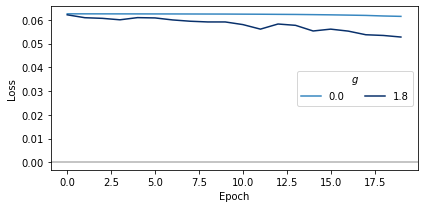

Learning took 7.7 sec.
SV evaluation took 0.5 sec
Computing reconstruction loss took 34.9 sec
Computing loss after shuffle took 1.4 sec
Sample 1
    0 0.0
    1 1.8
test_flipflop_gs_adam_train_wrec_N_256_lr0_005 0.0001953125 32 7.986380100250244


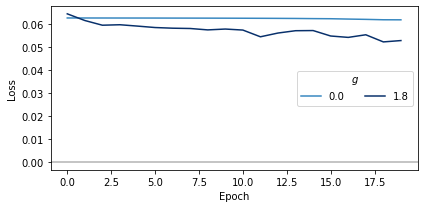

Learning took 8.0 sec.
SV evaluation took 0.5 sec
Computing reconstruction loss took 35.3 sec
Computing loss after shuffle took 1.5 sec
Computing EVs&SVs for all samples took 0.6 sec
Saved data to ..\..\data\neurips_2020\test_flipflop_gs_adam_train_wrec_N_256_lr0_005.pkl

file_name:
 test_mante_gs_adam_train_wrec_N_256_lr0_005
data_file:
 ..\..\data\neurips_2020\test_mante_gs_adam_train_wrec_N_256_lr0_005.pkl
Sample 0
    0 0.0
    1 1.8


C:\Users\frsch\code\Low-rank-notes\notebooks\neurips_2020\modules.py:234: UserWarning: Nominal g and wrec_init disagree: g = 1.80, g_wrec = 1.81
  warn("Nominal g and wrec_init disagree: g = %.2f, g_wrec = %.2f" % (g, g_wrec))


test_mante_gs_adam_train_wrec_N_256_lr0_005 0.0001953125 32 7.063514471054077


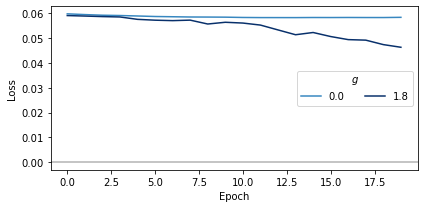

Learning took 7.1 sec.
SV evaluation took 0.5 sec
Computing reconstruction loss took 35.0 sec
Computing loss after shuffle took 1.1 sec
Sample 1
    0 0.0
    1 1.8
test_mante_gs_adam_train_wrec_N_256_lr0_005 0.0001953125 32 7.334574937820435


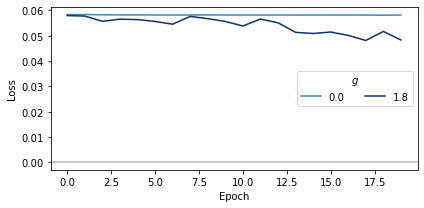

Learning took 7.3 sec.
SV evaluation took 0.5 sec
Computing reconstruction loss took 29.5 sec
Computing loss after shuffle took 1.1 sec
Computing EVs&SVs for all samples took 0.7 sec
Saved data to ..\..\data\neurips_2020\test_mante_gs_adam_train_wrec_N_256_lr0_005.pkl

file_name:
 test_romo_gs_adam_train_wrec_N_256_lr0_005
data_file:
 ..\..\data\neurips_2020\test_romo_gs_adam_train_wrec_N_256_lr0_005.pkl
Sample 0
    0 0.0
    1 1.8
test_romo_gs_adam_train_wrec_N_256_lr0_005 0.0001953125 32 4.079440355300903


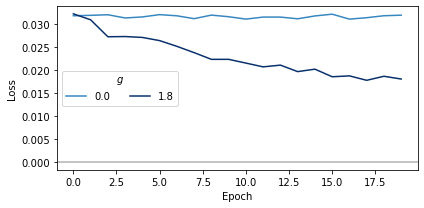

Learning took 4.1 sec.
SV evaluation took 0.5 sec
Computing reconstruction loss took 16.1 sec
Computing loss after shuffle took 0.6 sec
Sample 1
    0 0.0
    1 1.8
test_romo_gs_adam_train_wrec_N_256_lr0_005 0.0001953125 32 4.098814249038696


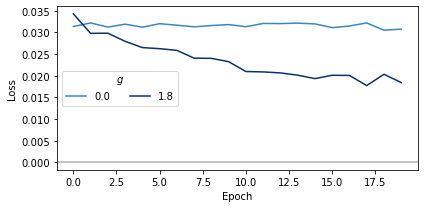

Learning took 4.1 sec.
SV evaluation took 0.5 sec
Computing reconstruction loss took 16.7 sec
Computing loss after shuffle took 0.7 sec
Computing EVs&SVs for all samples took 0.7 sec
Saved data to ..\..\data\neurips_2020\test_romo_gs_adam_train_wrec_N_256_lr0_005.pkl



In [6]:
# Run training
tasks_specs = [flipflop_specs, mante_specs, romo_specs]
for task_specs in tasks_specs:
    run_training(task_specs)